<a href="https://colab.research.google.com/github/jtj7387/AI_Capstone/blob/main/keras_colorization_final_sr_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [ ]:
# Proceed (y/n)? 이 뜨면 y 누르고 엔터
!pip uninstall keras

Uninstalling Keras-2.3.1:
  Would remove:
    /tensorflow-1.15.2/python3.7/Keras-2.3.1.dist-info/*
    /tensorflow-1.15.2/python3.7/docs/*
    /tensorflow-1.15.2/python3.7/keras/*
Proceed (y/n)? y
  Successfully uninstalled Keras-2.3.1


In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 27.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [ ]:
img_rows, img_cols = 256, 256 # 이미지 크기
channel = 3 # 채널 개수
batch_size = 4 # 한번에 넘기는 이미지 장수
epochs = 500 #10000 # 전체 이미지 학습 횟수
patience = 50 # loss 변화가 없을시 몇번 더 학습해볼건지 횟수
num_train_samples = 38 #529202 # train 이미지 개수
num_valid_samples = 1 #4268 # test 이미지 개수
num_classes = 313 # 색상 양자화한 수
kernel = 3
weight_decay = 1e-3
epsilon = 1e-8
nb_neighbors = 5
# temperature parameter T
T = 0.38

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 노트북 파일이 위치한 폴더명 입력
base_dir = '/content/drive/My Drive/2021_Spring_Capstone/'
# pts_in_hull.npy 파일이 위치한 폴더명 입력 - 미리 만들어서 pts_in_hull.npy 파일을 넣어놓아야 함
data_dir = '/content/drive/My Drive/2021_Spring_Capstone/data/'
# weight가 저장될 폴더명 입력 - 미리 만들어둘 필요 없음
weight_dir = '/content/drive/My Drive/2021_Spring_Capstone/weights/'


In [ ]:
import os

image_path = '/content/drive/My Drive/2021_Spring_Capstone/img/' # 원본 이미지 경로
save_path = '/content/drive/My Drive/2021_Spring_Capstone/r-img/'  # 리사이즈될/된 이미지 경로 - 미리 만들어둘 필요 없음

if not os.path.exists(save_path):
    os.makedirs(save_path)

if not os.path.exists(weight_dir):
    os.makedirs(weight_dir)

# save_path, weight_dir에 해당되는 폴더가 생성되었는지 확인 후 다음 셀 진행

### Resized image를 이미 한번 생성한 경우 바로 아래 셀은 실행할 필요 없음

In [ ]:
# resized image가 이미 생성되 있을 경우 여기 셀을 실행할 필요는 없음

from PIL import Image
import os


data_list = os.listdir(image_path) # 원본 이미지 경로 내 폴더들 list


# 모든 이미지 resize 후 저장하기
for name in data_list:
    # 이미지 열기
    im = Image.open(image_path + name)

    # 이미지 resize
    im = im.resize((256, 256))

    # 이미지 JPG로 저장
    im = im.convert('RGB')
    im.save(save_path + name)
    print('saved - {}'.format(name))

saved - Faceimg1,529.jpg
saved - Faceimg1,337.jpg
saved - Faceimg1,517.jpg
saved - Faceimg1,312.jpg
saved - Faceimg1,428.jpg
saved - Faceimg1,491.jpg
saved - Faceimg1,490.jpg
saved - Faceimg1,290.jpg
saved - Faceimg1,320.jpg
saved - Faceimg1,503.jpg
saved - Faceimg1,465.jpg
saved - Faceimg1,525.jpg
saved - Faceimg1,350.jpg
saved - Faceimg1,493.jpg
saved - Faceimg1,442.jpg
saved - Faceimg1,406.jpg
saved - Faceimg1,452.jpg
saved - Faceimg1,302.jpg
saved - Faceimg1,299.jpg
saved - Faceimg1,498.jpg
saved - Faceimg1,324.jpg
saved - Faceimg1,387.jpg
saved - Faceimg1,504.jpg
saved - Faceimg1,489.jpg
saved - Faceimg1,339.jpg
saved - Faceimg1,434.jpg
saved - Faceimg1,476.jpg
saved - Faceimg1,402.jpg
saved - Faceimg1,439.jpg
saved - Faceimg1,450.jpg
saved - Faceimg1,497.jpg
saved - Faceimg1,378.jpg
saved - Faceimg1,459.jpg
saved - Faceimg1,368.jpg
saved - Faceimg1,436.jpg
saved - Faceimg1,301.jpg
saved - Faceimg1,502.jpg
saved - Faceimg1,462.jpg
saved - Faceimg1,499.jpg
saved - Faceimg1,323.jpg


In [ ]:
import tensorflow as tf
import os
import random
from random import shuffle

import cv2 as cv
import numpy as np
import sklearn.neighbors as nn
#from keras.utils import Sequence
from tensorflow.keras.utils import Sequence


image_folder = save_path


def get_soft_encoding(image_ab, nn_finder, nb_q):
    h, w = image_ab.shape[:2]
    a = np.ravel(image_ab[:, :, 0])
    b = np.ravel(image_ab[:, :, 1])
    ab = np.vstack((a, b)).T
    # Get the distance to and the idx of the nearest neighbors
    dist_neighb, idx_neigh = nn_finder.kneighbors(ab)
    # Smooth the weights with a gaussian kernel
    sigma_neighbor = 5
    wts = np.exp(-dist_neighb ** 2 / (2 * sigma_neighbor ** 2))
    wts = wts / np.sum(wts, axis=1)[:, np.newaxis]
    # format the tar get
    y = np.zeros((ab.shape[0], nb_q))
    idx_pts = np.arange(ab.shape[0])[:, np.newaxis]
    y[idx_pts, idx_neigh] = wts
    y = y.reshape(h, w, nb_q)
    return y


class DataGenSequence(Sequence):
    def __init__(self, usage):
        self.usage = usage

        if usage == 'train':
            names_file = base_dir + 'train_names.txt'
        else:
            names_file = base_dir + 'valid_names.txt'

        with open(names_file, 'r') as f:
            self.names = f.read().splitlines()

        np.random.shuffle(self.names)

        # Load the array of quantized ab value
        q_ab = np.load(data_dir + 'pts_in_hull.npy')
        self.nb_q = q_ab.shape[0]
        # Fit a NN to q_ab
        self.nn_finder = nn.NearestNeighbors(n_neighbors=nb_neighbors, algorithm='ball_tree').fit(q_ab)

    def __len__(self):
        return int(np.ceil(len(self.names) / float(batch_size)))

    def __getitem__(self, idx):
        i = idx * batch_size

        out_img_rows, out_img_cols = img_rows // 4, img_cols // 4

        length = min(batch_size, (len(self.names) - i))
        batch_x = np.empty((length, img_rows, img_cols, 1), dtype=np.float32)
        batch_y = np.empty((length, out_img_rows, out_img_cols, self.nb_q), dtype=np.float32)

        for i_batch in range(length):
            name = self.names[i]
            filename = os.path.join(image_folder, name)
            # b: 0 <=b<=255, g: 0 <=g<=255, r: 0 <=r<=255.
            bgr = cv.imread(filename)
            # bgr = cv.resize(bgr, (img_rows, img_cols), cv.INTER_CUBIC)
            gray = cv.imread(filename, 0)
            # gray = cv.resize(gray, (img_rows, img_cols), cv.INTER_CUBIC)
            lab = cv.cvtColor(bgr, cv.COLOR_BGR2LAB)
            x = gray / 255.

            out_lab = cv.resize(lab, (out_img_rows, out_img_cols), cv.INTER_CUBIC)
            # Before: 42 <=a<= 226, 20 <=b<= 223
            # After: -86 <=a<= 98, -108 <=b<= 95
            out_ab = out_lab[:, :, 1:].astype(np.int32) - 128

            y = get_soft_encoding(out_ab, self.nn_finder, self.nb_q)

            if np.random.random_sample() > 0.5:
                x = np.fliplr(x)
                y = np.fliplr(y)

            batch_x[i_batch, :, :, 0] = x
            batch_y[i_batch] = y

            i += 1

        return batch_x, batch_y

    def on_epoch_end(self):
        np.random.shuffle(self.names)


def train_gen():
    return DataGenSequence('train')


def valid_gen():
    return DataGenSequence('valid')


def split_data():
    global num_train_samples, num_valid_samples
    names = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]

    num_samples = len(names)  # 1341430
    print('num_samples: ' + str(num_samples))

    num_train_samples = int(num_samples * 0.8) # 전체 학습 데이터 중 80%만 학습에 사용, 20%는 테스트 용도로 남겨둠
    print('num_train_samples: ' + str(num_train_samples))
    num_valid_samples = num_samples - num_train_samples
    print('num_valid_samples: ' + str(num_valid_samples))
    valid_names = random.sample(names, num_valid_samples)
    train_names = [n for n in names if n not in valid_names]
    shuffle(valid_names)
    shuffle(train_names)

    # with open('names.txt', 'w') as file:
    #     file.write('\n'.join(names))

    with open(base_dir + 'valid_names.txt', 'w') as file:
        file.write('\n'.join(valid_names))

    with open(base_dir + 'train_names.txt', 'w') as file:
        file.write('\n'.join(train_names))


if __name__ == '__main__':
    split_data()

num_samples: 3163
num_train_samples: 2530
num_valid_samples: 633


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.


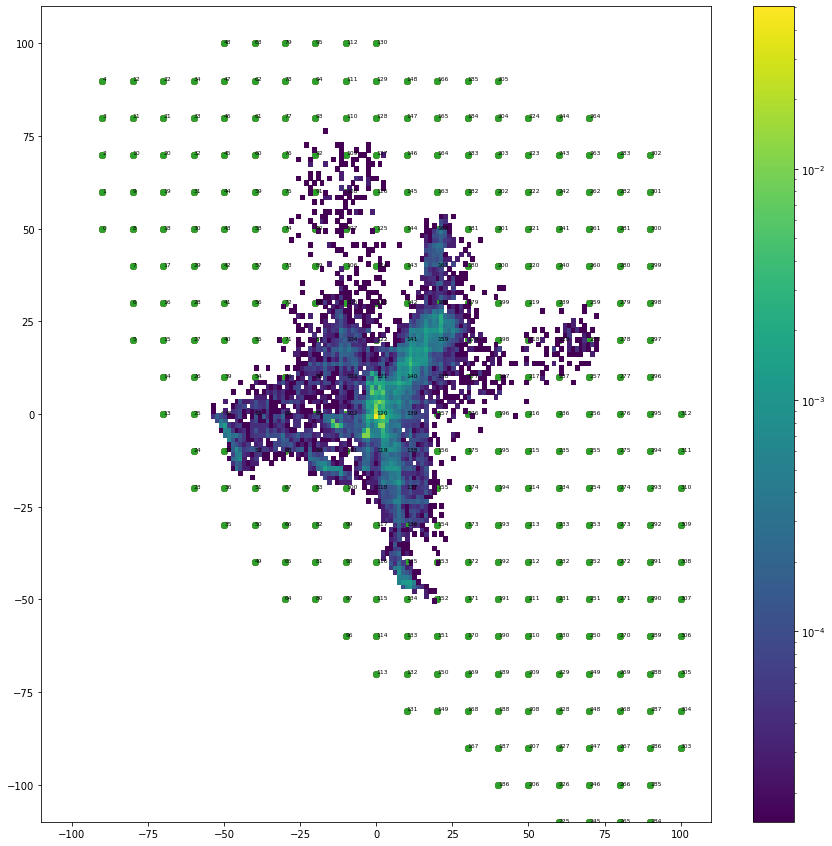

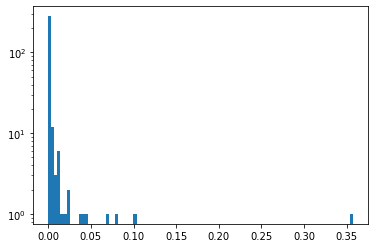

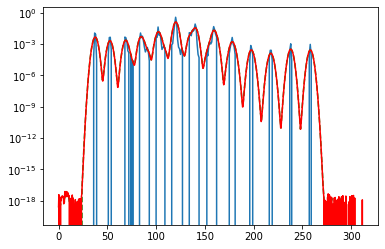

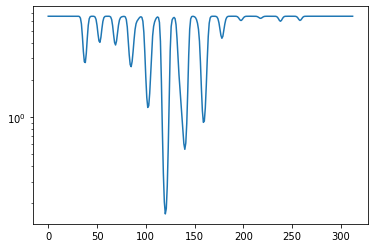

In [ ]:
import os

import cv2 as cv
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import numpy as np
import sklearn.neighbors as nn
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve


def load_data(size=64):
    image_folder = save_path
    names = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]
    np.random.shuffle(names)
    num_samples = 10
    X_ab = np.empty((num_samples, size, size, 2))
    for i in range(num_samples):
        name = names[i]
        filename = os.path.join(image_folder, name)
        bgr = cv.imread(filename)
        bgr = cv.resize(bgr, (size, size), cv.INTER_CUBIC)
        lab = cv.cvtColor(bgr, cv.COLOR_BGR2LAB)
        lab = lab.astype(np.int32)
        X_ab[i] = lab[:, :, 1:] - 128
    return X_ab


def compute_color_prior(X_ab, size=64, do_plot=False):
    # Load the gamut points location
    q_ab = np.load(data_dir + 'pts_in_hull.npy')
    #q_ab = np.load(os.path.join(data_dir, "/content/drive/My Drive/2021_Spring_Capstone/data/pts_in_hull.npy"))

    if do_plot:
        plt.figure(figsize=(15, 15))
        gs = gridspec.GridSpec(1, 1)
        ax = plt.subplot(gs[0])
        for i in range(q_ab.shape[0]):
            ax.scatter(q_ab[:, 0], q_ab[:, 1])
            ax.annotate(str(i), (q_ab[i, 0], q_ab[i, 1]), fontsize=6)
            ax.set_xlim([-110, 110])
            ax.set_ylim([-110, 110])

    npts, c, h, w = X_ab.shape
    X_a = np.ravel(X_ab[:, :, :, 0])
    X_b = np.ravel(X_ab[:, :, :, 1])
    X_ab = np.vstack((X_a, X_b)).T

    if do_plot:
        plt.hist2d(X_ab[:, 0], X_ab[:, 1], bins=100, normed=True, norm=LogNorm())
        plt.xlim([-110, 110])
        plt.ylim([-110, 110])
        plt.colorbar()
        plt.show()
        plt.clf()
        plt.close()

    # Create nearest neighbord instance with index = q_ab
    NN = 1
    nearest = nn.NearestNeighbors(n_neighbors=NN, algorithm='ball_tree').fit(q_ab)
    # Find index of nearest neighbor for X_ab
    dists, ind = nearest.kneighbors(X_ab)

    # We now count the number of occurrences of each color
    ind = np.ravel(ind)
    counts = np.bincount(ind)
    idxs = np.nonzero(counts)[0]
    prior_prob = np.zeros((q_ab.shape[0]))
    for i in range(q_ab.shape[0]):
        prior_prob[idxs] = counts[idxs]

    # We turn this into a color probability
    prior_prob = prior_prob / (1.0 * np.sum(prior_prob))

    # Save
    #np.save(os.path.join(data_dir, "/content/drive/My Drive/2021_Spring_Capstone/data/prior_prob.npy"), prior_prob)
    np.save(data_dir + 'prior_prob.npy', prior_prob)

    if do_plot:
        plt.hist(prior_prob, bins=100)
        plt.yscale("log")
        plt.show()


def smooth_color_prior(size=64, sigma=5, do_plot=False):
    #prior_prob = np.load(os.path.join(data_dir, "/content/drive/My Drive/2021_Spring_Capstone/data/prior_prob.npy"))
    prior_prob = np.load(data_dir + 'prior_prob.npy')
    # add an epsilon to prior prob to avoid 0 vakues and possible NaN
    prior_prob += 1E-3 * np.min(prior_prob)
    # renormalize
    prior_prob = prior_prob / (1.0 * np.sum(prior_prob))

    # Smooth with gaussian
    f = interp1d(np.arange(prior_prob.shape[0]), prior_prob)
    xx = np.linspace(0, prior_prob.shape[0] - 1, 1000)
    yy = f(xx)
    window = gaussian(2000, sigma)  # 2000 pts in the window, sigma=5
    smoothed = convolve(yy, window / window.sum(), mode='same')
    fout = interp1d(xx, smoothed)
    prior_prob_smoothed = np.array([fout(i) for i in range(prior_prob.shape[0])])
    prior_prob_smoothed = prior_prob_smoothed / np.sum(prior_prob_smoothed)

    # Save
    #file_name = os.path.join(data_dir, "/content/drive/My Drive/2021_Spring_Capstone/data/prior_prob_smoothed.npy")
    file_name = data_dir + 'prior_prob_smoothed.npy'
    np.save(file_name, prior_prob_smoothed)

    if do_plot:
        plt.plot(prior_prob)
        plt.plot(prior_prob_smoothed, "g--")
        plt.plot(xx, smoothed, "r-")
        plt.yscale("log")
        plt.show()


def compute_prior_factor(size=64, gamma=0.5, alpha=1, do_plot=False):
    #file_name = os.path.join(data_dir, "/content/drive/My Drive/2021_Spring_Capstone/data/prior_prob_smoothed.npy")
    file_name = data_dir + 'prior_prob_smoothed.npy'
    prior_prob_smoothed = np.load(file_name)

    u = np.ones_like(prior_prob_smoothed)
    u = u / np.sum(1.0 * u)

    prior_factor = (1 - gamma) * prior_prob_smoothed + gamma * u
    prior_factor = np.power(prior_factor, -alpha)

    # renormalize
    prior_factor = prior_factor / (np.sum(prior_factor * prior_prob_smoothed))

    #file_name = os.path.join(data_dir, "/content/drive/My Drive/2021_Spring_Capstone/data/prior_factor.npy")
    file_name = data_dir + 'prior_factor.npy'
    np.save(file_name, prior_factor)

    if do_plot:
        plt.plot(prior_factor)
        plt.yscale("log")
        plt.show()


if __name__ == '__main__':
    #data_dir = 'data/'
    do_plot = True

    X_ab = load_data()
    compute_color_prior(X_ab, do_plot=True) # 오류 원인
    smooth_color_prior(do_plot=True)
    compute_prior_factor(do_plot=True)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2



l2_reg = l2(1e-3)


def build_model():
    input_tensor = Input(shape=(img_rows, img_cols, 1))
    x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='conv1_1',
               kernel_initializer="he_normal",kernel_regularizer=l2_reg)(input_tensor)
    x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='conv1_2', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg, strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv2_1', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv2_2', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg,
               strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_3', kernel_initializer="he_normal",
               strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same', name='pred')(x)

    model = Model(inputs=input_tensor, outputs=outputs, name="ColorNet")
    return model


if __name__ == '__main__':
    with tf.device("/gpu:0"):
        encoder_decoder = build_model()
    print(encoder_decoder.summary())


    K.clear_session()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "ColorNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 256, 256, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 64, 64, 128)       147584    
___________________________________________

In [ ]:
prior_factor = np.load(data_dir + 'prior_factor.npy')
prior_factor = prior_factor.astype(np.float32)

def categorical_crossentropy_color(y_true, y_pred):
    q = 313
    y_true = K.reshape(y_true, (-1, q))
    y_pred = K.reshape(y_pred, (-1, q))

    idx_max = K.argmax(y_true, axis=1)
    weights = K.gather(prior_factor, idx_max)
    weights = K.reshape(weights, (-1, 1))

    # multiply y_true by weights
    y_true = y_true * weights

    cross_ent = K.categorical_crossentropy(y_pred, y_true)
    cross_ent = K.mean(cross_ent, axis=-1)

    return cross_ent

In [ ]:
import argparse

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from keras.utils import multi_gpu_model

from tensorflow.python.client import device_lib


if __name__ == '__main__':
    # Parse arguments
    ap = argparse.ArgumentParser()
    ap.add_argument("-p", "--pretrained", help="path to save pretrained model files")
    ap.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
    args = vars(ap.parse_args())
    pretrained_path = args["pretrained"]
    checkpoint_models_path = 'models/'

    # Callbacks
    tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
    model_names = weight_dir + 'model.{epoch:02d}-{loss:.4f}.h5'
    model_checkpoint = ModelCheckpoint(model_names, monitor='loss', verbose=1, save_best_only=True, period = 5) # epoch 5회마다 loss에 감소가 있을 경우 저장
    early_stop = EarlyStopping('loss', patience=patience) # 없애도 됨
    reduce_lr = ReduceLROnPlateau('loss', factor=0.5, patience=int(patience), verbose=1) # 수정할 부분


    class MyCbk(keras.callbacks.Callback):
        def __init__(self, model):
            keras.callbacks.Callback.__init__(self)
            self.model_to_save = model

        def on_epoch_end(self, epoch, logs=None):
            fmt = weight_dir + 'model.%02d-%.4f.h5'
            self.model_to_save.save(fmt % (epoch, logs['loss']))

    def get_available_gpus(): # 추가한 코드
        local_device_protos = device_lib.list_local_devices()
        return [x.name for x in local_device_protos if x.device_type == 'GPU']


    # Load our model, added support for Multi-GPUs # 삭제
    num_gpu = len(get_available_gpus())
    if num_gpu >= 2:
        with tf.device("/cpu:0"):
          model = build_model()
          if pretrained_path is not None:
              model.load_weights(pretrained_path)
        
        new_model = multi_gpu_model(model, gpus=num_gpu) # 오류
        # rewrite the callback: saving through the original model and not the multi-gpu model.
        model_checkpoint = MyCbk(model)
    else: # 이 부분만 살리기
        new_model = build_model()
        if pretrained_path is not None:
            new_model.load_weights(pretrained_path)
        

    sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, clipnorm=5.)
    new_model.compile(optimizer=sgd, loss='categorical_crossentropy') # no-rebal 버전
    #new_model.compile(optimizer=sgd, loss=categorical_crossentropy_color) # class rebal 버전

    #print(new_model.summary())

    # Final callbacks
    callbacks = [tensor_board, model_checkpoint, early_stop, reduce_lr]

    # Start Fine-tuning
    new_model.fit_generator(train_gen(),
                            steps_per_epoch=num_train_samples // batch_size,
                            validation_data=valid_gen(),
                            validation_steps=num_valid_samples // batch_size,
                            epochs=epochs,
                            verbose=1, callbacks=callbacks,
                            use_multiprocessing=True,
                            workers=8
                            )

Epoch 1/500
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
632/632 [==============================] - 160s 253ms/step - loss: 15.0065 - val_loss: 13.5481
Epoch 2/500
632/632 [==============================] - 141s 223ms/step - loss: 11.9252 - val_loss: 11.2666
Epoch 3/500
632/632 [==============================] - 141s 223ms/step - loss: 9.8326 - val_loss: 9.3217
Epoch 4/500
632/632 [==============================] - 141s 223ms/step - loss: 8.2071 - val_loss: 7.7332
Epoch 5/500
158/632 [======>.......................] - ETA: 48s - loss: 6.5970
Epoch 00005: loss improved from inf to 6.95424, saving model to /content/drive/My Drive/2021_Spring_Capstone/weights/model.05-6.9542.h5
632/632 [==============================] - 143s 227ms/step - loss: 6.9534 - val_loss: 6.5970
Epoch 6/500
632/632 [==============================] - 142s 224ms/step - loss: 5.9843 - val_loss: 5.8543
Epoch 7/500
632/632 [==============================] - 142s 224ms/ste